In [6]:
import os
import requests
import pandas as pd
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Get API key from environment variable
ALPHA_VANTAGE_API_KEY = os.getenv('ALPHA_VANTAGE_API_KEY')

# If you don't have a .env file, you can directly paste your API key here (not recommended for production)
# ALPHA_VANTAGE_API_KEY = 'YOUR_API_KEY'

# Base URL for Alpha Vantage API
BASE_URL = 'https://www.alphavantage.co/query'

In [7]:
print(ALPHA_VANTAGE_API_KEY)

Y39O8O7VRNRYERY0


In [8]:
def get_stock_time_series(symbol, interval='daily'):
    """
    Fetch stock time series data from Alpha Vantage
    
    Parameters:
    symbol (str): Stock symbol (e.g., 'AAPL')
    interval (str): Time interval - 'daily', 'weekly', or 'monthly'
    
    Returns:
    pandas.DataFrame: Stock data with dates as index
    """
    function = f'TIME_SERIES_{interval.upper()}'
    
    params = {
        'function': function,
        'symbol': symbol,
        'apikey': ALPHA_VANTAGE_API_KEY,
        'outputsize': 'compact'  # Returns the latest 100 data points
    }
    
    try:
        response = requests.get(BASE_URL, params=params)
        response.raise_for_status()  # Raise an exception for bad status codes
        data = response.json()
        
        # Extract time series data
        time_series_key = f'Time Series ({interval.title()})'
        if time_series_key not in data:
            print(f"Error: {data.get('Note', 'Unknown error')}")
            return None
            
        df = pd.DataFrame.from_dict(data[time_series_key], orient='index')
        
        # Clean up column names and convert to numeric
        df.columns = [col.split('. ')[1] for col in df.columns]
        df = df.apply(pd.to_numeric)
        
        return df
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return None

In [9]:
# Test the function with Apple stock
symbol = 'AAPL'
stock_data = get_stock_time_series(symbol)

if stock_data is not None:
    print(f"\nLast {len(stock_data)} days of {symbol} stock data:")
    print("\nFirst few rows:")
    print(stock_data.head())
    
    print("\nBasic statistics:")
    print(stock_data.describe())


Last 100 days of AAPL stock data:

First few rows:
               open      high       low   close    volume
2024-11-29  234.810  237.8100  233.9700  237.33  28481377
2024-11-27  234.465  235.6900  233.8101  234.93  33498439
2024-11-26  233.330  235.5700  233.3300  235.06  45986189
2024-11-25  231.460  233.2450  229.7400  232.87  90152832
2024-11-22  228.060  230.7199  228.0600  229.87  38168252

Basic statistics:
             open        high         low       close        volume
count  100.000000  100.000000  100.000000  100.000000  1.000000e+02
mean   225.461389  227.536958  223.380760  225.654800  4.944037e+07
std      6.471108    5.679726    6.670735    5.922233  3.095761e+07
min    199.090000  209.990000  196.000000  207.230000  2.811134e+07
25%    222.323750  224.720000  220.157500  222.305000  3.673414e+07
50%    225.830000  227.990000  224.075000  226.385000  4.340941e+07
75%    229.467500  230.744925  227.375000  229.010000  5.246293e+07
max    236.480000  237.810000  234.45

In [6]:
def get_company_overview(symbol):
    """
    Fetch company overview data from Alpha Vantage
    
    Parameters:
    symbol (str): Stock symbol (e.g., 'AAPL')
    
    Returns:
    dict: Company overview data
    """
    params = {
        'function': 'OVERVIEW',
        'symbol': symbol,
        'apikey': ALPHA_VANTAGE_API_KEY
    }
    
    try:
        response = requests.get(BASE_URL, params=params)
        response.raise_for_status()
        data = response.json()
        
        # Check if we got valid data
        if 'Symbol' not in data:
            print(f"Error: {data.get('Note', 'No data found for this symbol')}")
            return None
            
        # Convert numeric strings to float where appropriate
        numeric_fields = ['MarketCapitalization', 'EBITDA', 'PERatio', 'PEGRatio', 'BookValue', 
                         'DividendPerShare', 'DividendYield', '52WeekHigh', '52WeekLow']
        
        for field in numeric_fields:
            if field in data and data[field]:
                try:
                    data[field] = float(data[field])
                except ValueError:
                    pass
                    
        return data
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching company overview: {e}")
        return None

In [7]:
def display_company_summary(symbol):
    """
    Display a formatted summary of company information
    """
    overview = get_company_overview(symbol)
    if overview is None:
        return
    
    print(f"\n{'='*50}")
    print(f"Company Summary: {overview.get('Name', symbol)}")
    print(f"{'='*50}")
    print(f"Sector: {overview.get('Sector', 'N/A')}")
    print(f"Industry: {overview.get('Industry', 'N/A')}")
    print(f"Market Cap: ${overview.get('MarketCapitalization', 0):,.2f}")
    print(f"P/E Ratio: {overview.get('PERatio', 'N/A')}")
    print(f"52-Week High: ${overview.get('52WeekHigh', 'N/A')}")
    print(f"52-Week Low: ${overview.get('52WeekLow', 'N/A')}")
    print(f"Dividend Yield: {overview.get('DividendYield', 'N/A')}%")
    print(f"\nDescription:")
    print(f"{overview.get('Description', 'N/A')}")
    print(f"\n{'='*50}")

# Test with our previous stock
display_company_summary('AAPL')


Company Summary: Apple Inc
Sector: TECHNOLOGY
Industry: ELECTRONIC COMPUTERS
Market Cap: $3,587,432,776,000.00
P/E Ratio: 39.03
52-Week High: $237.81
52-Week Low: $163.49
Dividend Yield: 0.0043%

Description:
Apple Inc. is an American multinational technology company that specializes in consumer electronics, computer software, and online services. Apple is the world's largest technology company by revenue (totalling $274.5 billion in 2020) and, since January 2021, the world's most valuable company. As of 2021, Apple is the world's fourth-largest PC vendor by unit sales, and fourth-largest smartphone manufacturer. It is one of the Big Five American information technology companies, along with Amazon, Google, Microsoft, and Facebook.



In [8]:
def get_technical_indicators(symbol):
    """
    Fetch various technical indicators for a stock
    
    Parameters:
    symbol (str): Stock symbol (e.g., 'AAPL')
    
    Returns:
    dict: Technical indicators data
    """
    indicators = {}
    
    # Get RSI (Relative Strength Index)
    params_rsi = {
        'function': 'RSI',
        'symbol': symbol,
        'interval': 'daily',
        'time_period': 14,
        'series_type': 'close',
        'apikey': ALPHA_VANTAGE_API_KEY
    }
    
    # Get MACD (Moving Average Convergence/Divergence)
    params_macd = {
        'function': 'MACD',
        'symbol': symbol,
        'interval': 'daily',
        'series_type': 'close',
        'apikey': ALPHA_VANTAGE_API_KEY
    }
    
    try:
        # Fetch RSI
        rsi_response = requests.get(BASE_URL, params=params_rsi)
        rsi_data = rsi_response.json()
        if 'Technical Analysis: RSI' in rsi_data:
            rsi_values = pd.DataFrame.from_dict(rsi_data['Technical Analysis: RSI'], 
                                              orient='index')
            indicators['RSI'] = rsi_values
            
        # Wait a bit to avoid rate limiting
        import time
        time.sleep(12)  # Wait 12 seconds between API calls
        
        # Fetch MACD
        macd_response = requests.get(BASE_URL, params=params_macd)
        macd_data = macd_response.json()
        if 'Technical Analysis: MACD' in macd_data:
            macd_values = pd.DataFrame.from_dict(macd_data['Technical Analysis: MACD'], 
                                               orient='index')
            indicators['MACD'] = macd_values
            
        return indicators
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching technical indicators: {e}")
        return None

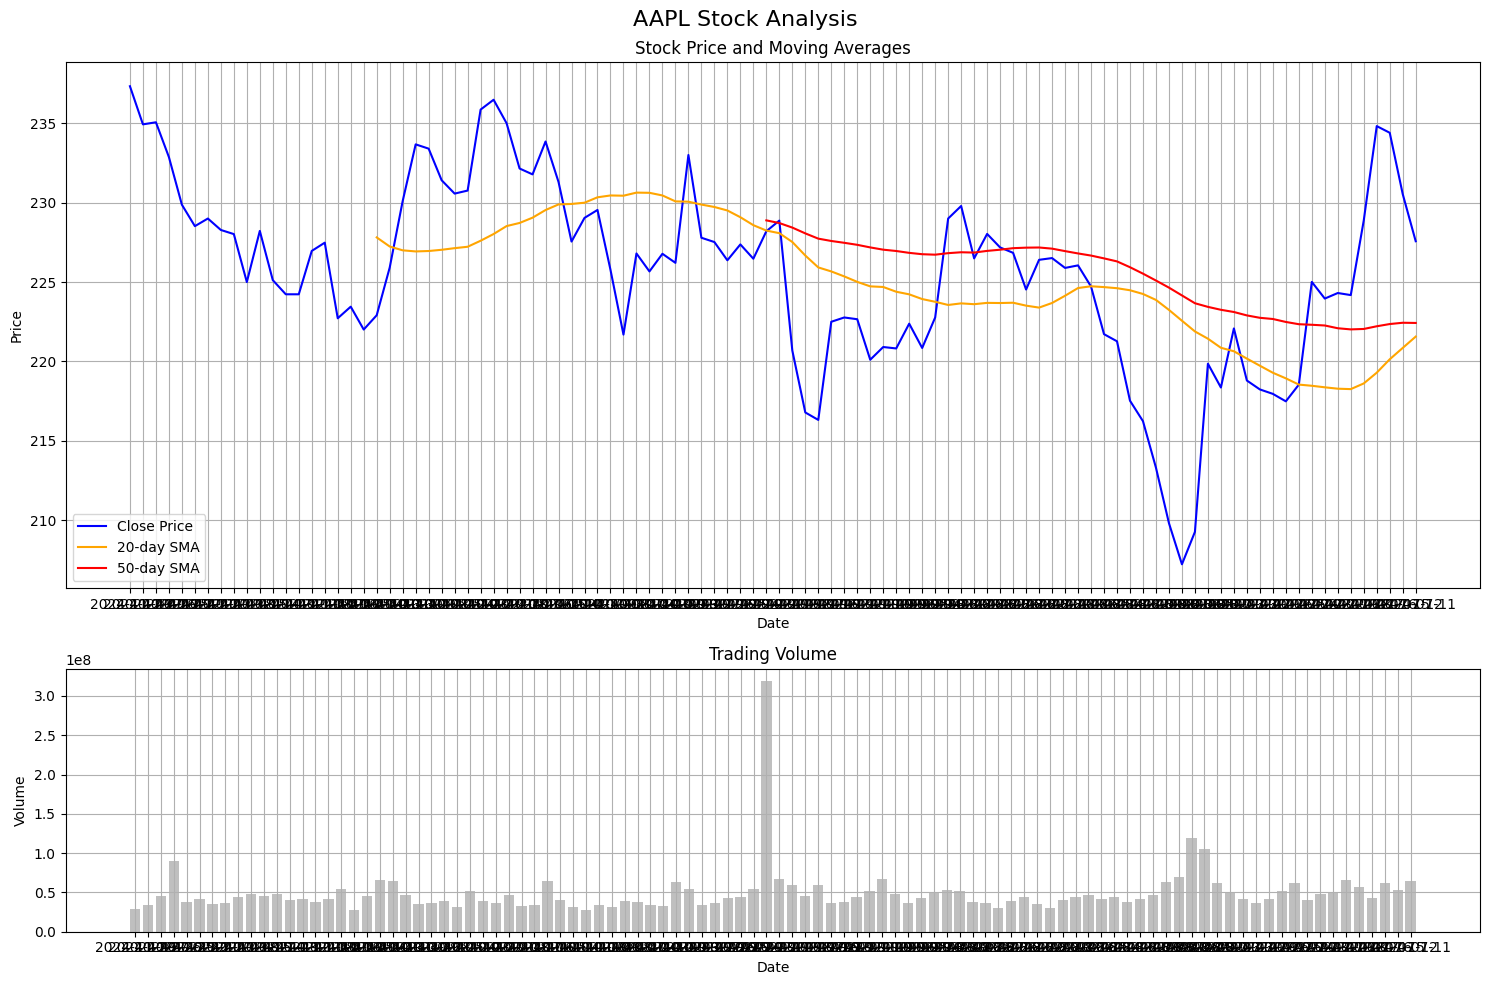

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_stock_analysis(symbol):
    """
    Create a comprehensive plot of stock price and technical indicators
    """
    # Get stock data
    stock_data = get_stock_time_series(symbol)
    if stock_data is None:
        return
        
    # Calculate simple moving averages
    stock_data['SMA20'] = stock_data['close'].rolling(window=20).mean()
    stock_data['SMA50'] = stock_data['close'].rolling(window=50).mean()
    
    # Create the visualization
    # plt.style.use('seaborn')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), height_ratios=[2, 1])
    fig.suptitle(f'{symbol} Stock Analysis', fontsize=16)
    
    # Plot stock price and moving averages
    ax1.plot(stock_data.index, stock_data['close'], label='Close Price', color='blue')
    ax1.plot(stock_data.index, stock_data['SMA20'], label='20-day SMA', color='orange')
    ax1.plot(stock_data.index, stock_data['SMA50'], label='50-day SMA', color='red')
    ax1.set_title('Stock Price and Moving Averages')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True)
    
    # Plot volume
    ax2.bar(stock_data.index, stock_data['volume'], color='gray', alpha=0.5)
    ax2.set_title('Trading Volume')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Volume')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Test the visualization
plot_stock_analysis('AAPL')

In [13]:
def calculate_prediction_indicators(symbol):
    """
    Calculate prediction indicators including Bollinger Bands
    and price momentum
    
    Parameters:
    symbol (str): Stock symbol (e.g., 'AAPL')
    
    Returns:
    DataFrame: Original data with prediction indicators
    """
    # Get stock data
    stock_data = get_stock_time_series(symbol)
    if stock_data is None:
        return None
        
    # Calculate 20-day moving average and standard deviation
    stock_data['MA20'] = stock_data['close'].rolling(window=20).mean()
    rolling_std = stock_data['close'].rolling(window=20).std()
    
    # Calculate Bollinger Bands
    stock_data['Upper_Band'] = stock_data['MA20'] + (rolling_std * 2)
    stock_data['Lower_Band'] = stock_data['MA20'] - (rolling_std * 2)
    
    # Calculate momentum indicators
    stock_data['Price_Change'] = stock_data['close'].pct_change()
    stock_data['Price_Momentum'] = stock_data['Price_Change'].rolling(window=5).mean()
    
    # Calculate potential support and resistance levels
    stock_data['Support'] = stock_data['low'].rolling(window=20).min()
    stock_data['Resistance'] = stock_data['high'].rolling(window=20).max()
    
    return stock_data

def analyze_price_trends(data):
    """
    Analyze price trends and generate insights
    """
    if data is None or len(data) < 20:
        return "Insufficient data for analysis"
        
    latest = data.iloc[0]
    
    analysis = []
    
    # Check Bollinger Bands position
    if latest['close'] > latest['Upper_Band']:
        analysis.append("Stock is trading above upper Bollinger Band - potentially overbought")
    elif latest['close'] < latest['Lower_Band']:
        analysis.append("Stock is trading below lower Bollinger Band - potentially oversold")
        
    # Check momentum
    if latest['Price_Momentum'] > 0:
        analysis.append(f"Positive momentum with {latest['Price_Momentum']:.2%} average daily gain")
    else:
        analysis.append(f"Negative momentum with {latest['Price_Momentum']:.2%} average daily loss")
        
    # Check support/resistance
    analysis.append(f"Current support level: ${latest['Support']:.2f}")
    analysis.append(f"Current resistance level: ${latest['Resistance']:.2f}")
    
    return "\n".join(analysis)

In [14]:
def generate_stock_report(symbol, output_format='csv'):
    """
    Generate a comprehensive stock analysis report
    
    Parameters:
    symbol (str): Stock symbol
    output_format (str): 'csv' or 'html'
    """
    # Get all our data
    overview = get_company_overview(symbol)
    pred_data = calculate_prediction_indicators(symbol)
    
    if overview is None or pred_data is None:
        return "Unable to generate report - data fetching failed"
    
    # Create report dataframe
    latest_data = pred_data.iloc[0]
    
    report_data = {
        'Metric': [
            'Company Name',
            'Current Price',
            'MA20',
            'Upper Band',
            'Lower Band',
            'Support Level',
            'Resistance Level',
            'Price Momentum',
            'Market Cap',
            'P/E Ratio',
            'Sector',
            'Industry'
        ],
        'Value': [
            overview.get('Name', symbol),
            f"${latest_data['close']:.2f}",
            f"${latest_data['MA20']:.2f}",
            f"${latest_data['Upper_Band']:.2f}",
            f"${latest_data['Lower_Band']:.2f}",
            f"${latest_data['Support']:.2f}",
            f"${latest_data['Resistance']:.2f}",
            f"{latest_data['Price_Momentum']:.2%}",
            f"${overview.get('MarketCapitalization', 0):,.2f}",
            overview.get('PERatio', 'N/A'),
            overview.get('Sector', 'N/A'),
            overview.get('Industry', 'N/A')
        ]
    }
    
    report_df = pd.DataFrame(report_data)
    
    # Add trend analysis
    trend_analysis = analyze_price_trends(pred_data)
    
    # Export based on format
    timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
    if output_format == 'csv':
        filename = f"{symbol}_analysis_{timestamp}.csv"
        report_df.to_csv(filename, index=False)
        
        # Save trend analysis to a separate text file
        with open(f"{symbol}_trends_{timestamp}.txt", 'w') as f:
            f.write(trend_analysis)
            
    elif output_format == 'html':
        filename = f"{symbol}_analysis_{timestamp}.html"
        html_content = f"""
        <html>
            <head>
                <title>{symbol} Stock Analysis</title>
                <style>
                    body {{ font-family: Arial, sans-serif; margin: 20px; }}
                    table {{ border-collapse: collapse; width: 100%; }}
                    th, td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
                    th {{ background-color: #f2f2f2; }}
                </style>
            </head>
            <body>
                <h1>{symbol} Stock Analysis Report</h1>
                {report_df.to_html(index=False)}
                <h2>Trend Analysis</h2>
                <pre>{trend_analysis}</pre>
            </body>
        </html>
        """
        with open(filename, 'w') as f:
            f.write(html_content)
            
    return f"Report generated: {filename}"

# Test the report generation
print(generate_stock_report('AAPL', output_format='html'))

Report generated: AAPL_analysis_20241130_132947.html


In [15]:
def get_intraday_data(symbol, interval='5min'):
    """
    Fetch intraday stock data
    
    Parameters:
    symbol (str): Stock symbol
    interval (str): Time interval between data points ('1min', '5min', '15min', '30min', '60min')
    
    Returns:
    DataFrame: Intraday stock data
    """
    params = {
        'function': 'TIME_SERIES_INTRADAY',
        'symbol': symbol,
        'interval': interval,
        'apikey': ALPHA_VANTAGE_API_KEY,
        'outputsize': 'compact'
    }
    
    try:
        response = requests.get(BASE_URL, params=params)
        response.raise_for_status()
        data = response.json()
        
        # Extract time series data
        time_series_key = f'Time Series ({interval})'
        if time_series_key not in data:
            print(f"Error: {data.get('Note', 'Unknown error')}")
            return None
            
        df = pd.DataFrame.from_dict(data[time_series_key], orient='index')
        
        # Clean column names
        df.columns = [col.split('. ')[1] for col in df.columns]
        df = df.apply(pd.to_numeric)
        
        # Sort index in ascending order
        df = df.sort_index(ascending=True)
        
        return df
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching intraday data: {e}")
        return None

Fetching intraday data for AAPL...

Last 5 intraday data points:
                         open    high      low    close  volume
2024-11-29 16:35:00  237.3950  237.47  237.360  237.410     749
2024-11-29 16:40:00  237.4100  237.50  237.410  237.480    3223
2024-11-29 16:45:00  237.4994  237.50  237.385  237.400    4280
2024-11-29 16:50:00  237.3850  237.40  237.300  237.325    7640
2024-11-29 16:55:00  237.3700  237.49  237.300  237.445    6979

Comparing performance of multiple stocks...


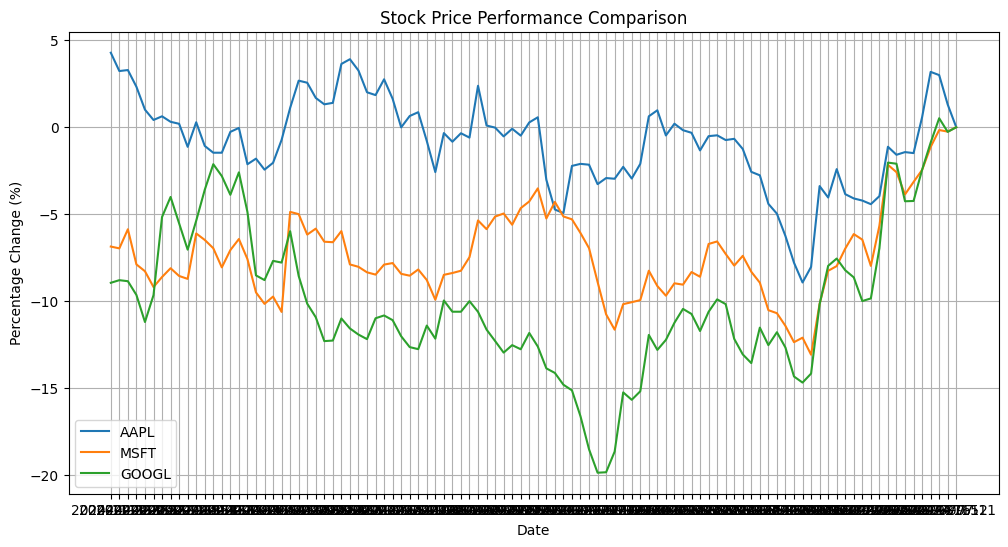


Comparative performance summary:
                AAPL      MSFT     GOOGL
2024-07-17  0.575647 -2.458764 -2.451905
2024-07-16  3.185833 -1.139213 -0.889152
2024-07-15  3.001274 -0.162745  0.517325
2024-07-12  1.305093 -0.252914 -0.269440
2024-07-11  0.000000  0.000000  0.000000


In [17]:
import time
def compare_stocks(symbols, days=30):
    """
    Compare performance of multiple stocks
    
    Parameters:
    symbols (list): List of stock symbols
    days (int): Number of days to compare
    
    Returns:
    DataFrame: Comparative performance data
    """
    comparison_data = {}
    
    for symbol in symbols:
        # Get daily stock data
        stock_data = get_stock_time_series(symbol)
        if stock_data is not None:
            # Calculate percentage change from first day
            first_price = stock_data['close'].iloc[-1]
            stock_data['pct_change'] = (stock_data['close'] / first_price - 1) * 100
            comparison_data[symbol] = stock_data['pct_change']
            
        # Wait to avoid hitting API rate limit
        time.sleep(12)
    
    # Combine all stocks into one DataFrame
    comparison_df = pd.DataFrame(comparison_data)
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    for symbol in symbols:
        if symbol in comparison_df.columns:
            plt.plot(comparison_df.index, comparison_df[symbol], label=symbol)
    
    plt.title('Stock Price Performance Comparison')
    plt.xlabel('Date')
    plt.ylabel('Percentage Change (%)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return comparison_df

# Test the new functions
test_symbols = ['AAPL', 'MSFT', 'GOOGL']

print("Fetching intraday data for AAPL...")
intraday_data = get_intraday_data('AAPL')
if intraday_data is not None:
    print("\nLast 5 intraday data points:")
    print(intraday_data.tail())

print("\nComparing performance of multiple stocks...")
comparison_data = compare_stocks(test_symbols)
if comparison_data is not None:
    print("\nComparative performance summary:")
    print(comparison_data.tail())

In [18]:
def screen_stocks(symbols, criteria):
    """
    Screen stocks based on specified criteria
    
    Parameters:
    symbols (list): List of stock symbols to screen
    criteria (dict): Dictionary of screening criteria
    Example criteria:
    {
        'min_market_cap': 1000000000,  # $1B minimum
        'max_pe': 30,                  # Maximum P/E ratio
        'min_dividend_yield': 1,       # Minimum dividend yield %
        'min_price': 10,              # Minimum stock price
        'max_price': 100              # Maximum stock price
    }
    
    Returns:
    DataFrame: Stocks that meet the criteria
    """
    screened_stocks = []
    
    for symbol in symbols:
        # Get company overview
        overview = get_company_overview(symbol)
        if overview is None:
            continue
            
        # Get current stock data
        stock_data = get_stock_time_series(symbol)
        if stock_data is None:
            continue
            
        current_price = float(stock_data['close'].iloc[0])
        
        # Check if stock meets all criteria
        meets_criteria = True
        
        if 'min_market_cap' in criteria and overview.get('MarketCapitalization'):
            if float(overview['MarketCapitalization']) < criteria['min_market_cap']:
                meets_criteria = False
                
        if 'max_pe' in criteria and overview.get('PERatio'):
            if float(overview['PERatio']) > criteria['max_pe']:
                meets_criteria = False
                
        if 'min_dividend_yield' in criteria and overview.get('DividendYield'):
            if float(overview['DividendYield']) < criteria['min_dividend_yield']:
                meets_criteria = False
                
        if 'min_price' in criteria:
            if current_price < criteria['min_price']:
                meets_criteria = False
                
        if 'max_price' in criteria:
            if current_price > criteria['max_price']:
                meets_criteria = False
                
        if meets_criteria:
            screened_stocks.append({
                'Symbol': symbol,
                'Company': overview.get('Name', 'N/A'),
                'Price': current_price,
                'Market_Cap': float(overview.get('MarketCapitalization', 0)),
                'P/E': float(overview.get('PERatio', 0)),
                'Dividend_Yield': float(overview.get('DividendYield', 0)),
                'Sector': overview.get('Sector', 'N/A')
            })
            
        time.sleep(12)  # Respect API rate limits
        
    return pd.DataFrame(screened_stocks)

Testing stock screener...

Screened Stocks:
  Symbol                Company   Price    Market_Cap    P/E  Dividend_Yield  \
0   AAPL              Apple Inc  237.33  3.587433e+12  39.03          0.0043   
1   MSFT  Microsoft Corporation  423.46  3.148374e+12  35.00          0.0078   
2  GOOGL   Alphabet Inc Class A  168.95  2.076902e+12  22.38          0.0047   
3   META    Meta Platforms Inc.  574.32  1.449865e+12  27.13          0.0035   

       Sector  
0  TECHNOLOGY  
1  TECHNOLOGY  
2  TECHNOLOGY  
3  TECHNOLOGY  

Creating comprehensive dashboard for AAPL...


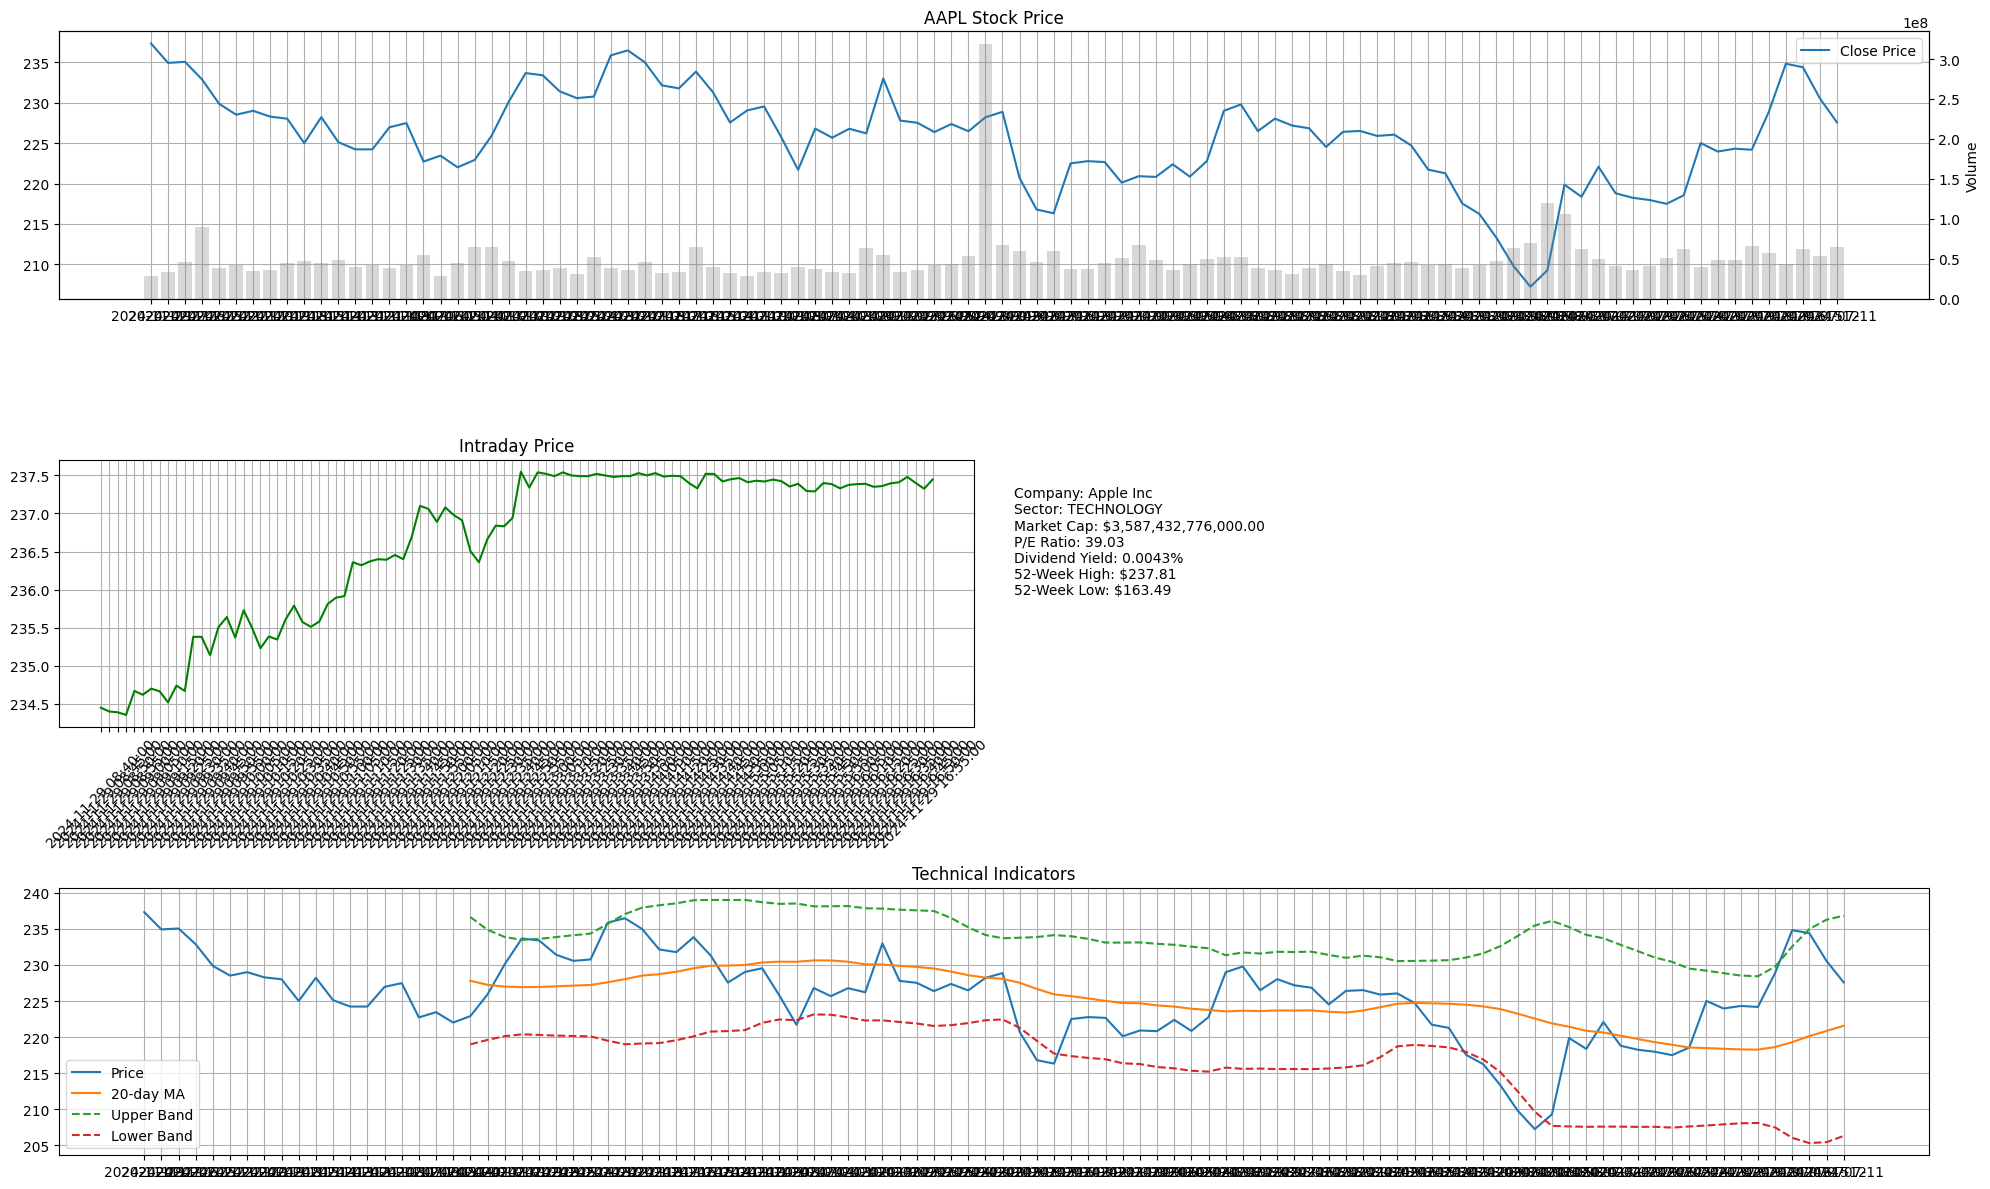


Technical Analysis Summary:
Negative momentum with nan% average daily loss
Current support level: $nan
Current resistance level: $nan


In [19]:
def create_stock_analysis_dashboard(symbol):
    """
    Create a comprehensive stock analysis dashboard
    
    Parameters:
    symbol (str): Stock symbol to analyze
    """
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(20, 12))
    
    # Define grid layout
    gs = fig.add_gridspec(3, 2)
    
    # 1. Price and Volume Chart
    ax1 = fig.add_subplot(gs[0, :])
    stock_data = get_stock_time_series(symbol)
    if stock_data is not None:
        ax1.plot(stock_data.index, stock_data['close'], label='Close Price')
        ax1.set_title(f'{symbol} Stock Price')
        ax1.grid(True)
        ax1.legend()
        
        # Add volume as bar chart on secondary axis
        ax1_volume = ax1.twinx()
        ax1_volume.bar(stock_data.index, stock_data['volume'], alpha=0.3, color='gray')
        ax1_volume.set_ylabel('Volume')
    
    # 2. Intraday Price Chart
    ax2 = fig.add_subplot(gs[1, 0])
    intraday_data = get_intraday_data(symbol)
    if intraday_data is not None:
        ax2.plot(intraday_data.index, intraday_data['close'], color='green')
        ax2.set_title('Intraday Price')
        ax2.grid(True)
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    
    # 3. Company Overview
    ax3 = fig.add_subplot(gs[1, 1])
    overview = get_company_overview(symbol)
    if overview is not None:
        ax3.axis('off')
        overview_text = (
            f"Company: {overview.get('Name', 'N/A')}\n"
            f"Sector: {overview.get('Sector', 'N/A')}\n"
            f"Market Cap: ${float(overview.get('MarketCapitalization', 0)):,.2f}\n"
            f"P/E Ratio: {overview.get('PERatio', 'N/A')}\n"
            f"Dividend Yield: {overview.get('DividendYield', 'N/A')}%\n"
            f"52-Week High: ${overview.get('52WeekHigh', 'N/A')}\n"
            f"52-Week Low: ${overview.get('52WeekLow', 'N/A')}"
        )
        ax3.text(0, 0.9, overview_text, fontsize=10, verticalalignment='top')
    
    # 4. Prediction Indicators
    ax4 = fig.add_subplot(gs[2, :])
    pred_data = calculate_prediction_indicators(symbol)
    if pred_data is not None:
        ax4.plot(pred_data.index, pred_data['close'], label='Price')
        ax4.plot(pred_data.index, pred_data['MA20'], label='20-day MA')
        ax4.plot(pred_data.index, pred_data['Upper_Band'], label='Upper Band', linestyle='--')
        ax4.plot(pred_data.index, pred_data['Lower_Band'], label='Lower Band', linestyle='--')
        ax4.set_title('Technical Indicators')
        ax4.grid(True)
        ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print analysis summary
    if pred_data is not None:
        print("\nTechnical Analysis Summary:")
        print(analyze_price_trends(pred_data))

# Test the new functions
print("Testing stock screener...")
test_symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
criteria = {
    'min_market_cap': 1000000000000,  # $1T minimum
    'max_pe': 40,
    'min_price': 100,
    'max_price': 1000
}
screened_stocks = screen_stocks(test_symbols, criteria)
print("\nScreened Stocks:")
print(screened_stocks)

print("\nCreating comprehensive dashboard for AAPL...")
create_stock_analysis_dashboard('AAPL')

In [10]:
def get_stock_news_sentiment(symbol, limit=10, topics=None, time_from=None):
    """
    Fetch news and sentiment data for a stock
    
    Parameters:
    symbol (str): Stock symbol (e.g., 'AAPL')
    limit (int): Number of news articles to return (max 1000)
    topics (list): List of topics to filter (e.g., ['technology', 'earnings'])
    time_from (str): Start time in YYYYMMDDTHHMM format (e.g., '20240328T1000')
    
    Returns:
    dict: News and sentiment data
    """
    params = {
        'function': 'NEWS_SENTIMENT',
        'tickers': symbol,
        'limit': min(limit, 1000),  # Ensure we don't exceed API max
        'sort': 'LATEST',
        'apikey': ALPHA_VANTAGE_API_KEY
    }
    
    # Add optional parameters if provided
    if topics:
        params['topics'] = ','.join(topics)
    if time_from:
        params['time_from'] = time_from
    
    try:
        response = requests.get(BASE_URL, params=params)
        data = response.json()
        print(data)
        
        if 'feed' in data:
            # Process and structure the news data
            processed_news = []
            for article in data['feed']:
                news_item = {
                    'title': article.get('title'),
                    'url': article.get('url'),
                    'time_published': article.get('time_published'),
                    'summary': article.get('summary'),
                    'source': article.get('source'),
                    'overall_sentiment_score': article.get('overall_sentiment_score'),
                    'overall_sentiment_label': article.get('overall_sentiment_label'),
                }
                
                # Get stock-specific sentiment if available
                ticker_sentiments = article.get('ticker_sentiment', [])
                for sentiment in ticker_sentiments:
                    if sentiment.get('ticker') == symbol:
                        news_item['ticker_sentiment_score'] = sentiment.get('ticker_sentiment_score')
                        news_item['ticker_sentiment_label'] = sentiment.get('ticker_sentiment_label')
                        break
                
                processed_news.append(news_item)
            
            return {
                'symbol': symbol,
                'items_count': len(processed_news),
                'news_data': processed_news
            }
            
        else:
            print(f"Error: {data.get('Note', 'No news data available')}")
            return None
            
    except Exception as e:
        print(f"Error fetching news and sentiment data: {e}")
        return None



# Test the new functionality
if __name__ == "__main__":
    test_symbol = 'AAPL'
    print("\nFetching news and sentiment data...")
    news_data = get_stock_news_sentiment(
        test_symbol,
        limit=5,
        topics=['technology', 'earnings']
    )
    
    if news_data:
        print(f"\nLatest news for {test_symbol}:")
        for item in news_data['news_data']:
            print(f"\nTitle: {item['title']}")
            print(f"Sentiment: {item['overall_sentiment_label']} (Score: {item['overall_sentiment_score']})")
            print(f"Published: {item['time_published']}")
            print(f"Summary: {item['summary'][:200]}...")


Fetching news and sentiment data...
{'items': '50', 'sentiment_score_definition': 'x <= -0.35: Bearish; -0.35 < x <= -0.15: Somewhat-Bearish; -0.15 < x < 0.15: Neutral; 0.15 <= x < 0.35: Somewhat_Bullish; x >= 0.35: Bullish', 'relevance_score_definition': '0 < x <= 1, with a higher score indicating higher relevance.', 'feed': [{'title': "Amazon's Focus Shift To Black Friday From Cyber Monday Is Paying Off, Says Gene Munster: 'Small Changes To Profitability Can Have Measurable Impact To Earnings' - Amazon.com  ( NASDAQ:AMZN ) ", 'url': 'https://www.benzinga.com/24/11/42253350/amazons-focus-shift-to-black-friday-from-cyber-monday-is-paying-off-says-gene-munster-small-changes-to-profitabil', 'time_published': '20241130T080051', 'authors': ['Rounak Jain'], 'summary': "Amazon.com Inc. AMZN has shifted its focus from Cyber Monday to Black Friday for the second year in a row and is reaping the benefits of this move, according to Deepwater Asset Management's Gene Munster. This strategic pivot

In [4]:
hello = """
**Meta Platforms, Inc. (META) Analysis**\n\n**Market Position and Trend Analysis**\n---------------------------\n\nThe current price of $613.78 indicates a stable market position for Meta Platforms, Inc. (META). The daily change of 0.0212% suggests a minor fluctuation in the stock's performance. With a trading volume of 13032595, the liquidity is relatively high, indicating that investors are actively participating in the market.\n\n**Key Growth Indicators and Potential Risks**\n--------------------------------------\n\n* Revenue growth: Not available\n* Net income: Not available\n* Profit margin: Not available\n* Market cap: Not available\n\nHowever, it's essential to note that Meta Platforms, Inc. is a technology giant with significant revenue from its advertising business. While the company's financial data is not publicly disclosed, its market capitalization suggests a substantial value.\n\nPotential risks include increased competition in the tech industry, regulatory scrutiny, and economic downturns.\n\n**News Sentiment Impact on Stock Performance**\n--------------------------------------------\n\nThe overall sentiment score of 0.22636806 indicates a slightly positive news sentiment. However, the presence of several class-action lawsuits against other companies (Unisys Corporation, WM Technology, Inc., Xiao-I Corporation, Iris Energy Limited, and Elanco Animal Health Incorporated) may have a negative impact on Meta Platforms, Inc.\n\n**Notable Fundamental Strengths or Weaknesses**\n---------------------------------------------\n\nUnfortunately, the fundamental data is not available, making it challenging to assess the company's financial health. However, as a technology giant with significant revenue from advertising, Meta Platforms, Inc. has the potential for substantial growth in the future.\n\n**Three Most Important Actionable Insights**\n\n1. **Monitor Regulatory Developments**: As Meta Platforms, Inc. continues to operate in a rapidly evolving regulatory environment, it's essential to monitor any changes in laws or regulations that may impact the company's business.\n2. **Evaluate Class-Action Lawsuits**: The presence of several class-action lawsuits against other companies may have a negative impact on Meta Platforms, Inc.'s stock performance. Investors should carefully evaluate the potential risks and benefits associated with these lawsuits.\n3. **Keep an Eye on Revenue Growth**: As one of the largest technology companies in the world, Meta Platforms, Inc.'s revenue growth is crucial to its long-term success. Investors should closely monitor any updates or announcements regarding the company's revenue growth.\n\nIn conclusion, while Meta Platforms, Inc.'s fundamental data is not publicly available, its market capitalization suggests a substantial value. Investors should exercise caution when considering the potential risks and benefits associated with class-action lawsuits and monitor regulatory developments to make informed investment decisions.
"""

hello1 = """
**Market Position and Trend Analysis**\n\nThe current price of Meta (META) stock is $613.78, with a daily change of 0.0212%, indicating a relatively stable market position. The trading volume of 13,032,195 units suggests moderate activity, which may be influenced by various factors such as news sentiment and financial performance.\n\n**Growth Analysis**\n\nThe provided revenue growth rate is -100.00%, indicating a significant decline in revenue over the past year. Similarly, the net income growth rate also shows a decline of -100.00%. These high negative growth rates are indicative of challenging market conditions, intense competition, or possibly unforeseen events affecting Meta's business.\n\n**Financial Health Assessment**\n\nThe current financial metrics for Meta are not available, which limits our analysis of its financial health. However, the provided ratios and metrics give us some insights:\n\n* The Current Ratio is 0.00, indicating a liquidity issue or potential insolvency concerns.\n* The Profit Margin is 0.00%, suggesting that Meta may not be generating any profit or may have high operating costs.\n\n**News Sentiment Impact on Stock Performance**\n\nThe overall sentiment score for Meta's recent headlines is 0.22636806, which falls within the neutral range. While there are some negative news stories related to other companies (e.g., Unisys Corporation, WM Technology, Inc., Xiao-I Corporation), their impact on Meta's stock price appears to be limited.\n\n**Three Most Important Actionable Insights**\n\n1. **Revenue and Net Income Growth Rates**: The significant declines in revenue and net income growth rates (-100.00%) suggest that Meta is facing intense challenges in its core business. Investors should closely monitor the company's efforts to revitalize its financial performance.\n2. **Liquidity Concerns**: The Current Ratio of 0.00 indicates potential liquidity issues for Meta. Investors should be cautious about the company's ability to meet its short-term obligations and may want to consider this when evaluating its creditworthiness.\n3. **Profitability Concerns**: The Profit Margin of 0.00% suggests that Meta may not be generating any profit or has high operating costs. This could indicate operational inefficiencies or an unsustainable business model, which investors should carefully assess before making investment decisions.\n\nIn conclusion, the provided numerical data indicates a relatively stable market position for Meta's stock, but with significant concerns regarding revenue and net income growth rates, liquidity issues, and profitability. Investors should exercise caution and closely monitor the company's efforts to address these challenges."
"""

print(hello1)


**Market Position and Trend Analysis**

The current price of Meta (META) stock is $613.78, with a daily change of 0.0212%, indicating a relatively stable market position. The trading volume of 13,032,195 units suggests moderate activity, which may be influenced by various factors such as news sentiment and financial performance.

**Growth Analysis**

The provided revenue growth rate is -100.00%, indicating a significant decline in revenue over the past year. Similarly, the net income growth rate also shows a decline of -100.00%. These high negative growth rates are indicative of challenging market conditions, intense competition, or possibly unforeseen events affecting Meta's business.

**Financial Health Assessment**

The current financial metrics for Meta are not available, which limits our analysis of its financial health. However, the provided ratios and metrics give us some insights:

* The Current Ratio is 0.00, indicating a liquidity issue or potential insolvency concerns.
* Th